In [44]:
import pandas as pd
import seaborn as sns
import numpy as np
import orjson as orjson

import matplotlib.pyplot as plt
import warnings
import matplotlib

In [19]:
path = '/scratch/potem/'
new_file = 'stream_day1_parsed.pkl.gz'
save_path = '/scratch/potem/tweet-delete/'
file_name = 'sample-day1.jsonl'

In [1]:
all_data = []
with open(f'{path}{file_name}', 'r') as file:
    data = file.readlines()

In [21]:
for obj in data:
        k = orjson.loads(obj)

        if ('data' not in k) and ('created_at' not in k['data']):
            continue
        if ('includes' not in k) and ('users' not in k['includes']):
            continue
        
        all_data.append([k['data']['created_at'], 
                     k['includes']['users'][0]['id'],
                     k['includes']['users'][0]['public_metrics']['tweet_count']
                    ])
        
df = pd.DataFrame(data=all_data, columns=['created_at', 'id', 'tweet_count'])
df.to_pickle(f'{save_path}{new_file}')

In [23]:
df_read = pd.read_pickle(f'{save_path}{new_file}')

In [24]:
df_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3754644 entries, 0 to 3754643
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   created_at   object
 1   id           object
 2   tweet_count  int64 
dtypes: int64(1), object(2)
memory usage: 85.9+ MB


In [25]:
df_read['count'] = df_read.groupby(
        ['id']
    )['id'].transform('count')

In [27]:
df_new = df_read.loc[df_read['count'] != 1].copy()

In [28]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1555858 entries, 0 to 3754642
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   created_at   1555858 non-null  object
 1   id           1555858 non-null  object
 2   tweet_count  1555858 non-null  int64 
 3   count        1555858 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 59.4+ MB


In [29]:
df_new = df_new.drop(['count'], axis=1)

In [31]:
df_new.head()

,created_at,id,tweet_count
0,2021-12-18T01:45:08.000Z,1226393005206061059,40006
1,2021-12-18T01:45:08.000Z,1226393005206061059,40006
2,2021-12-18T01:45:08.000Z,1172038122646822912,102168
3,2021-12-18T01:45:08.000Z,941022373,65166
4,2021-12-18T01:45:08.000Z,731313173542764544,74067


In [32]:
df_new = df_new.sort_values(by=['created_at'], ascending=True)

In [33]:
df_new['tweet_shift'] = df_new.groupby(['id'])['tweet_count'].shift(
    periods=1)

In [34]:
df_new.head()

,created_at,id,tweet_count,tweet_shift
3464056,2021-12-17T16:06:28.000Z,1330503754957938694,8021,NaN
3115447,2021-12-17T16:06:32.000Z,824070656224436224,209320,NaN
3464064,2021-12-17T16:06:43.000Z,1038541302936129536,9453,NaN
3463998,2021-12-17T16:06:44.000Z,1312444122783838208,12672,NaN
3299,2021-12-18T01:45:08.000Z,1059632084204093440,42938,NaN


In [35]:
df_new = df_new.loc[~df_new['tweet_shift'].isnull()]
# df_test = df_active
df_new['estimated_deletion'] = (df_new['tweet_count'] - df_new['tweet_shift'])
# df_active['estimated_deletion'] = (df_active['tweet_count'] - df_active['tweet_shift']) / df_active['delay']


In [37]:
df_new.loc[df_new['estimated_deletion'] < 0]

,created_at,id,tweet_count,tweet_shift,estimated_deletion
1877,2021-12-18T01:46:02.000Z,38198962,2083,2089.0,-6.0
15302,2021-12-18T01:50:41.000Z,1386830117121429505,4371,4372.0,-1.0
17195,2021-12-18T01:51:33.000Z,1355248356868685825,873,874.0,-1.0
21260,2021-12-18T01:53:24.000Z,1145953772952150016,77763335,77763337.0,-2.0
29497,2021-12-18T01:57:11.000Z,895611574315909120,94101,94102.0,-1.0
...,...,...,...,...,...
3752507,2021-12-19T02:12:16.000Z,1386443219446026242,317925,317993.0,-68.0
3752810,2021-12-19T02:12:24.000Z,1284969566553219072,248,249.0,-1.0
3753095,2021-12-19T02:12:32.000Z,1005531267012726784,44303,44308.0,-5.0
3753830,2021-12-19T02:12:50.000Z,2979096319,4,29.0,-25.0


In [38]:
df_neagtive = df_new.loc[df_new['estimated_deletion'] < 0].copy()

In [57]:
df_neagtive = df_neagtive.loc[df_neagtive['estimated_deletion'] <= -10]

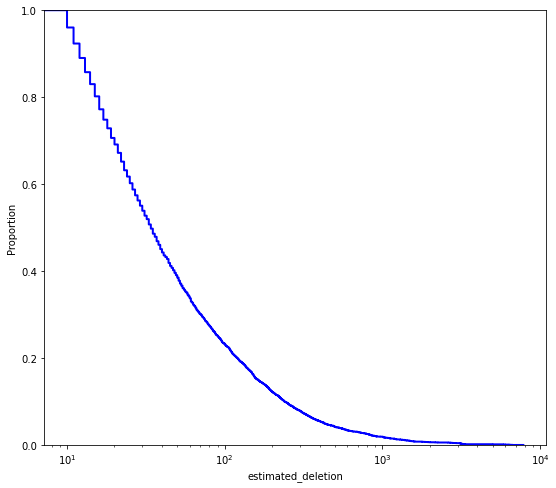

In [58]:
x = df_neagtive['estimated_deletion'] * (-1)
legend_1 = 'estimated'
filename = 'stream'
fontsize = 26
    
fig, ax = plt.subplots(figsize=(9, 8))

sns.ecdfplot(x, 
             complementary=True,
             label=legend_1,
             color='blue',
             ax=ax,
            linewidth=2,)
ax.set_xscale('log')
plt.show()